In [ ]:
#Mojo of reproducibility
import torch
import random
import numpy as np

def set_seed(seed):
  #PyTorch
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  #Numpy
  np.random.seed(seed)
  #Python_random
  random.seed(seed)
  #CuDNN (when using CUDA)
  if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Define the model class

In [ ]:
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
from torch import nn
import librosa

In [ ]:
class wav2Vec_transferModel(nn.Module):
    def __init__(self, pretrained_model_name="r-f/wav2vec-english-speech-emotion-recognition"):
        super().__init__()
        
        # Load pre-trained model
        self.model = Wav2Vec2Model.from_pretrained(pretrained_model_name)
        
        # Freeze the pre-trained Wav2Vec2 model
        # Only the last classifying layers will be trained
        for param in self.model.parameters():
            param.requires_grad = False
                        
        # Define dropout layer to avoid overfitting in the classifier
        self.dropout = nn.Dropout(0.2)
        
        # Attaching a new classifying layers for emotion label and emotion strength
        self.classifier_emo = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            self.dropout,
            nn.Linear(64, 6)
        )
        
        self.classifier_strength = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            self.dropout,
            nn.Linear(64, 3)
        )
        
        # Initialize weights by Xavier initialization
        self.init_weights()

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    
    def forward(self, inputs):        
        # Forward pass through the Wav2Vec2 model to extract the hidden states
        # Disable gradient calculation for the Wav2Vec2 model part
        # Input is a feature extracted by Wav2Vec2FeatureExtractor beforehand
        with torch.no_grad(): 
            outputs = self.model.wav2vec2(input_values=inputs.input_values, attention_mask=inputs.attention_mask)
            # Extract the last hidden state.
            # The last hidden state is a tensor of shape (batch_size, sequence_length, hidden_size)
            # Use mean pooling over the sequenth length to get a fixed-size representation
            last_hidden_state_pooled = outputs.last_hidden_state.mean(1) 
        
        # Pass the hidden states through the classifier
        logits_emo = self.model.classifier_emo(last_hidden_state_pooled)
        logits_strength = self.model.classifier_strength(last_hidden_state_pooled)
        
        # Return the logits for both tasks
        return logits_emo, logits_strength
            

Create dataset using featureExtractor corresponding to the model

In [78]:
import pandas as pd

df = pd.read_csv("../data/featuresAndLabels.csv")
df.drop(columns=df.columns[1:174], inplace=True)
df.head()

clipName         N         A         D    F    S    H       low  \
0  1022_ITS_ANG_XX  0.000000  0.454545  0.545455  0.0  0.0  0.0  0.000000   
1  1037_ITS_ANG_XX  0.500000  0.200000  0.200000  0.1  0.0  0.0  0.000000   
2  1060_ITS_NEU_XX  0.900000  0.000000  0.000000  0.0  0.1  0.0  0.000000   
3  1075_ITS_NEU_XX  0.909091  0.000000  0.090909  0.0  0.0  0.0  0.181818   
4  1073_IOM_DIS_XX  0.300000  0.000000  0.600000  0.0  0.1  0.0  0.200000   

     medium      high  
0  0.272727  0.727273  
1  0.300000  0.700000  
2  0.200000  0.800000  
3  0.090909  0.727273  
4  0.200000  0.600000

In [89]:
row = df.iloc[0]
print([[row['N'],row['A'],row['D'],row['F'],row['S'],row['H']]])
print(torch.argmax(torch.tensor([[row['N'],row['A'],row['D'],row['F'],row['S'],row['H']]])).item())

[[np.float64(0.0), np.float64(0.4545454545454545), np.float64(0.5454545454545454), np.float64(0.0), np.float64(0.0), np.float64(0.0)]]
2


In [91]:
# Get the true labels for the emotion class and strength from soft labels
def get_true_labels_emo(row):
    logit = [row['N'],row['A'],row['D'],row['F'],row['S'],row['H']]
    trueLabel = torch.argmax(torch.tensor(logit)).item()
    return trueLabel
def get_true_labels_strength(row):
    logit = [row['low'],row['medium'],row['high']]
    trueLabel = torch.argmax(torch.tensor(logit)).item()
    return trueLabel

# Append the true labels for emotion class and strength to the dataframe
df['trueLabel_emo'] = df.apply(get_true_labels_emo, axis=1)
df['trueLabel_strength'] = df.apply(get_true_labels_strength, axis=1)
df.head()

clipName         N         A         D    F    S    H       low  \
0  1022_ITS_ANG_XX  0.000000  0.454545  0.545455  0.0  0.0  0.0  0.000000   
1  1037_ITS_ANG_XX  0.500000  0.200000  0.200000  0.1  0.0  0.0  0.000000   
2  1060_ITS_NEU_XX  0.900000  0.000000  0.000000  0.0  0.1  0.0  0.000000   
3  1075_ITS_NEU_XX  0.909091  0.000000  0.090909  0.0  0.0  0.0  0.181818   
4  1073_IOM_DIS_XX  0.300000  0.000000  0.600000  0.0  0.1  0.0  0.200000   

     medium      high  trueLabel_emo  trueLabel_strength  
0  0.272727  0.727273              2                   2  
1  0.300000  0.700000              0                   2  
2  0.200000  0.800000              0                   2  
3  0.090909  0.727273              0                   2  
4  0.200000  0.600000              2                   2

In [ ]:
df['trueLabel_emo'].value_counts()

trueLabel_emo
0    4414
1    1071
3     677
2     563
4     367
5     350
Name: count, dtype: int64

Distribution of emo_class is quite skewed. Stratify the ratio of each class in train, val, and test dataset as follows

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
train_list = []
val_list = []
test_list = []

# Iterate through each unique label in the 'trueLabel_emo' column
for label in df['trueLabel_emo'].unique():
    subset = df[df['trueLabel_emo'] == label]
    
    # Shuffle the subset to add extra randomness
    # This is important to ensure that same actor's samples are concentrated in the same split
    subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split into train (80%), temp (20%)
    train, temp = train_test_split(subset, test_size=0.2, random_state=42)
    
    # Split temp into val (10%) and test (10%)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

# Concatenate all class splits
# Shuffle the result to ensure randomness in classes
df_train = pd.concat(train_list).sample(frac=1, random_state=42).reset_index(drop=True)
df_val   = pd.concat(val_list).sample(frac=1, random_state=42).reset_index(drop=True)
df_test  = pd.concat(test_list).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
print(f"Length of each dataset: {len(df_train), len(df_val), len(df_test)}")


Length of each dataset: (5951, 744, 747)


<Axes: xlabel='trueLabel_emo'>

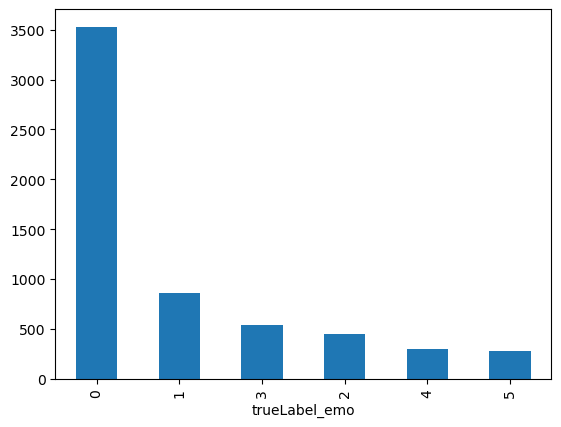

In [ ]:
df_train['trueLabel_emo'].value_counts().plot(kind="bar")

<Axes: xlabel='trueLabel_emo'>

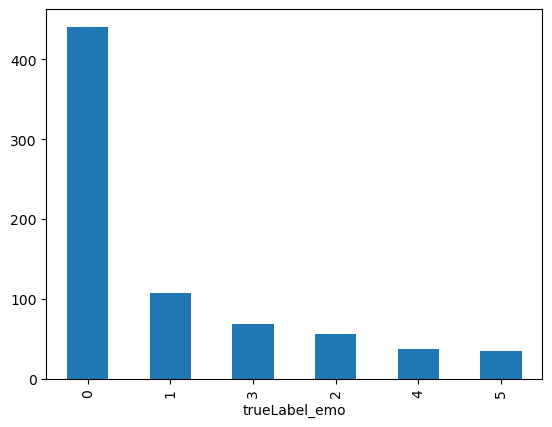

In [103]:
df_val['trueLabel_emo'].value_counts().plot(kind="bar")

<Axes: xlabel='trueLabel_emo'>

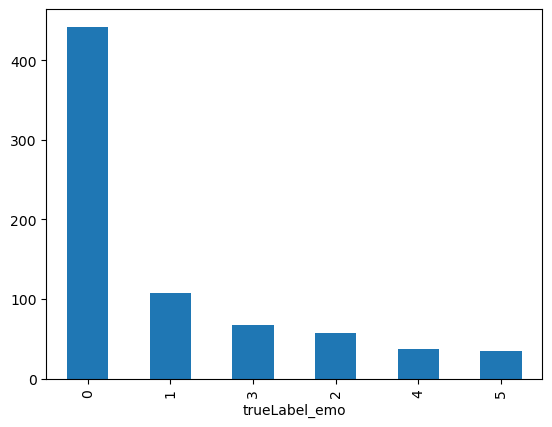

In [104]:
df_test['trueLabel_emo'].value_counts().plot(kind="bar")

Stratifying result looks good. Now, attach the feature to each using the feature_extractor corresponding to the model.

In [106]:
def extractFeatures(row):
    # Load the audio file
    audio_path = "../../crema-d-mirror/AudioWAV/" + row['clipName'] + ".wav"
    audio, sr = librosa.load(audio_path, sr=16000)
    
    # Extract features using Wav2Vec2FeatureExtractor
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("r-f/wav2vec-english-speech-emotion-recognition")
    features = feature_extractor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
    
    return features

df_train['features'] = df_train.apply(extractFeatures, axis=1)
df_val['features'] = df_val.apply(extractFeatures, axis=1)
df_test['features'] = df_test.apply(extractFeatures, axis=1)

loading configuration file preprocessor_config.json from cache at /Users/takehararyoutarou/.cache/huggingface/hub/models--r-f--wav2vec-english-speech-emotion-recognition/snapshots/2c59b3f6092ca069fbf79629eeadd13b9f243ce8/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "Wav2Vec2ProcessorWithLM",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

loading configuration file preprocessor_config.json from cache at /Users/takehararyoutarou/.cache/huggingface/hub/models--r-f--wav2vec-english-speech-emotion-recognition/snapshots/2c59b3f6092ca069fbf79629eeadd13b9f243ce8/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "pr

In [110]:
df_train.head()

clipName         N    A         D         F         S    H  low  \
0  1039_IWL_SAD_XX  0.300000  0.0  0.200000  0.100000  0.400000  0.0  0.0   
1  1007_WSI_SAD_XX  0.272727  0.0  0.181818  0.000000  0.545455  0.0  0.0   
2  1027_IWL_HAP_XX  0.600000  0.1  0.100000  0.000000  0.000000  0.2  0.1   
3  1063_TSI_FEA_XX  0.111111  0.0  0.000000  0.777778  0.111111  0.0  0.0   
4  1046_DFA_NEU_XX  0.900000  0.0  0.000000  0.000000  0.000000  0.1  0.0   

     medium      high  trueLabel_emo  trueLabel_strength  \
0  0.200000  0.800000              4                   2   
1  0.454545  0.545455              4                   2   
2  0.400000  0.500000              0                   2   
3  0.222222  0.777778              3                   2   
4  0.300000  0.700000              0                   2   

                         features  
0  [input_values, attention_mask]  
1  [input_values, attention_mask]  
2  [input_values, attention_mask]  
3  [input_values, attention_mask]  
4  [input_values, attention_mask]

Now, create customDataset & dataLoader for this.
Also, create randomWeightedSampler to mend the distribution issue in the training dataset.

In [138]:
# Create dataset
from torch.utils.data import Dataset

class voiceDataset(Dataset):
    def __init__(self, features, emotionLabels, strengthLabels):
        self.features = features
        self.emotionLabels = emotionLabels
        self.strengthLabels = strengthLabels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {'features':self.features[idx], 
                'emotionLabel':self.emotionLabels[idx], 
                'strengthLabel':self.strengthLabels[idx]
        }   

train_dataSet = voiceDataset(df_train['features'].tolist(), df_train.iloc[:,1:7].values, df_train.iloc[:,7:10].values)
val_dataSet = voiceDataset(df_val['features'].tolist(), df_val.iloc[:,1:7].values, df_val.iloc[:,7:10].values)
test_dataSet = voiceDataset(df_test['features'].tolist(), df_test.iloc[:,1:7].values, df_test.iloc[:,7:10].values)


from torch.utils.data import DataLoader, WeightedRandomSampler

# Create a weighted random sampler to balance the dataset
class_counts = df_train['trueLabel_emo'].value_counts().sort_index()
weights = 1.0 / class_counts
norm_weights = weights / weights.sum()
sample_weights = df_train['trueLabel_emo'].map(norm_weights)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create data loaders
train_loader = DataLoader(train_dataSet, batch_size=256, sampler=sampler)
val_loader = DataLoader(val_dataSet, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataSet, batch_size=1, shuffle=False)

Define the training process
- Use KL loss since the focus is predicting the nuanced soft-labeled probability
- However, apply the custom `weightedKLloss` to better predict the under-sampled emotion class. Basically, it's weighing the "distance" of under-sampled class more in KL divergence.
- Final loss will be calculated based on loss on emotion label and loss on strength label. Since predicting emotion is more important than predicting strength, each loss is weighted by ratio of 8:2

In [ ]:
class WeightedKLLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedKLLoss, self).__init__()
        self.class_weights = class_weights

    def forward(self, log_probs, target_probs):
        # Apply class weights to target probs
        weighted_targets = target_probs * self.class_weights.unsqueeze(0)
        # Normalize the weighted target to probability distribution
        weighted_targets = weighted_targets / weighted_targets.sum(dim=1, keepdim=True) 

        # Compute the KL divergence loss
        loss = weighted_targets * log_probs
        
        #
        return -loss.sum(dim=1).mean()


In [141]:
from torch import nn


In [163]:
class WeightedKLLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedKLLoss, self).__init__()
        self.class_weights = class_weights  # Tensor of shape [num_classes]

    def forward(self, log_probs, target_probs):
        # log_probs: log_softmax output [B, C]
        # target_probs: soft targets [B, C]

        # Apply class weights to target probs
        weighted_targets = target_probs * self.class_weights.unsqueeze(0)  # [B, C]
        weighted_targets = weighted_targets / weighted_targets.sum(dim=1, keepdim=True)  # re-normalize

        loss = weighted_targets*(weighted_targets * log_probs)
        print(loss)
        return -loss.sum(dim=1).mean()


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the trainer & validator function
def train_validate_model(learning_rate, trainDataLoader, validationDataLoader, num_epochs, weightFlag=False):

    set_seed(42)

    #Get the GPU as a device if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Instantiate the model
    model = wav2Vec_transferModel()

    # Moving the model to GPU if available
    model.to(device)

    #Prepare the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #Prepare the error function
    if weightFlag == False:
        criterion = nn.KLDivLoss(reduction='batchmean')
    if weightFlag == True:
        criterion = WeightedKLLoss(class_weights=torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], device=device))

    #Prepare the scheduler
    #Reduce the learning rate by 0.1 if the validation loss does not decrease for 3 epochs
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    #Prepare the DataLoader
    train_data_loader = trainDataLoader
    validation_data_loader = validationDataLoader

    #Placeholder for minimum validation loss
    min_val_loss = float('inf')

    for epoch in range(num_epochs):
        #set the model to training mode
        model.train()

        total_loss = 0 #Placeholder for training loss per epoch
        for batch in train_data_loader:
            feature = batch['features'].to(device)
            emotionLabel = batch['emotionLabel'].to(device)
            strengthLabel = batch['strengthLabel'].to(device)

            optimizer.zero_grad()
            emotionOutput, strengthOutput = model(feature)
            #Calculate the log-probabilities of the output
            emotionOutput_log = F.log_softmax(emotionOutput, dim=1)
            strengthOutput_log = F.log_softmax(strengthOutput, dim=1)
            
            #Calculate the loss for emotion head
            emo_loss = criterion(emotionOutput_log, emotionLabel)
            #Calculate the loss for strength head
            strength_loss = criterion(strengthOutput_log, strengthLabel)
            #Combine two losses to make a total loss. 
            #Put more weight on the emotion loss (7:3). Detecting emotion is more critical
            loss = 0.8*emo_loss + 0.2*strength_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        #Validate the model
        model.eval() #Set the model to evaluation mode
        with torch.no_grad():
            total_samples = 0 #Total output for accuracy calculation
            emoCorrect = 0 #Amount of correct prediction for accuracy calculation
            strengthCorrect = 0
            total_val_loss = 0 #Placeholder for validation loss per epoch
            
            for batch in validation_data_loader:
                feature = batch['features'].to(device)
                emotionLabel = batch['emotionLabel'].to(device)
                strengthLabel = batch['strengthLabel'].to(device)
                #Forward pass
                emotionOutput, strengthOutput = model(feature)
                #Calculate the log-probabilities of the output
                emotionOutput_log = F.log_softmax(emotionOutput, dim=1)
                strengthOutput_log = F.log_softmax(strengthOutput, dim=1)
                
                emo_loss = criterion(emotionOutput_log, emotionLabel)
                strength_loss = criterion(strengthOutput_log, strengthLabel )
                total_val_loss += 0.8*emo_loss + 0.2*strength_loss
                
                # Get predicted emotion class & target emotion class
                emo_predicted = torch.argmax(emotionOutput, dim=1)
                emo_target = torch.argmax(emotionLabel, dim=1)
                
                # Get predicted strength class & target emotion class
                strength_predicted = torch.argmax(strengthOutput,dim=1)
                strength_target = torch.argmax(strengthLabel, dim=1 )
                
                emoCorrect += (emo_predicted == emo_target).sum().item()
                strengthCorrect += (strength_predicted ==strength_target).sum().item()
                
                #Get total number of samples per epoch
                total_samples += emotionLabel.size(0)

            emo_accuracy = emoCorrect / total_samples
            strength_accuracy = strengthCorrect / total_samples

            #pass the validation loss to the scheduler
            scheduler.step(total_val_loss)

            if epoch == 0:
                min_val_loss = total_val_loss #Instantiate the min_val_loss at the first epoch
                if save == True:
                    torch.save(model.state_dict(), 'bestWav2Vec.pth')
            #Save the model if the validation loss is the lowest
            elif total_val_loss < min_val_loss:
                min_val_loss = total_val_loss
                if save == True:
                    torch.save(model.state_dict(), 'bestWav2Vec.pth')
                    print(f"Model saved after Epoch: {epoch+1}")
                        

    #Return the minimum validation loss for hyperparameter tuning
    return min_val_loss

In [ ]:
train_validate_model(learning_rate=1e-5, trainDataLoader=train_loader, validationDataLoader=val_loader, num_epochs=10, weightFlag=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bestModel = wav2Vec_transferModel()

bestModel.load_state_dict(torch.load('bestWav2Vec.pth',map_location=device))

bestModel.eval() #Set the bestModel to evaluation mode
bestModel.to(device)

with torch.no_grad():
  total = 0 #Total output for accuracy calculation
  emoCorrect = 0 #Amount of correct prediction for accuracy calculation
  strengthCorrect = 0
  emoPredList = [] #Placeholder for the predicted labels
  emoTargetList = [] #Placeholder for the target labels
  strengthPredList = []
  strengthTargetList = []
  
  for batch in test_loader:
      feature = batch['features'].to(device)
      emoLabel = batch['emotionLabel'].to(device)
      strengthLabel = batch['strengthLabel'].to(device)
      
      emoOutput, strengthOutput = bestModel(feature)
      
      emoPredicted = torch.argmax(emoOutput, dim = 1)
      emoTarget = torch.argmax(emoLabel, dim=1)
      
      emoPredList.append(emoPredicted.cpu().numpy())
      emoTargetList.append(emoTarget.cpu().numpy())
      
      strengthPredicted = torch.argmax(strengthOutput, dim=1)
      strengthTarget = torch.argmax(strengthLabel, dim=1)
      
      strengthPredList.append(strengthPredicted.cpu().numpy())
      strengthTargetList.append(strengthTarget.cpu().numpy())
      
      total += emoLabel.size(0)
      emoCorrect += (emoPredicted == emoTarget).sum().item()
      strengthCorrect += (strengthPredicted == strengthTarget).sum().item()
      
  print(f"Emotion Accuracy: {emoCorrect/total:.4f}")
  print(f"Strength Accuracy: {strengthCorrect/total:.4f}")


In [ ]:
# Print out the confusion matrix  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_emo = confusion_matrix(emoTargetList, emoPredList)
cm_strength = confusion_matrix(strengthTargetList, strengthPredList)

emo_label = ['Neutral', 'Anger', 'Disgust', 'Fear', 'Sad', 'Happy']
strength_label = ['Low', 'Medium', 'High']

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left plot
sns.heatmap(cm_emo, annot=True, fmt='d', cmap='Reds',
            xticklabels=emo_label, yticklabels=emo_label, ax=axes[0])
axes[0].set_title('Emotion prediction')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Right plot
sns.heatmap(cm_strength, annot=True, fmt='d', cmap='Greens',
            xticklabels=strength_label, yticklabels=strength_label, ax=axes[1])
axes[1].set_title('Strength prediction')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()
